# pc

> Point Cloud data manipulation

In [ ]:
#| default_exp cli/pc

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import zarr
import numpy as np
from matplotlib import pyplot as plt
import moraine.cli as mc
import moraine as mr

In [ ]:
#| export
import logging
import glob
from pathlib import Path
import zarr
import numpy as np
import numexpr as ne
import time
from typing import Callable

import dask
from dask import array as da
from dask.distributed import Client, LocalCluster, progress

from moraine.cli.logging import mc_logger
import moraine as mr
import moraine.cli as mc
from moraine.utils_ import ngjit
from moraine.cli import mk_clean_dir, dask_to_zarr, dask_from_zarr

In [ ]:
#| export
@mc_logger
def gix2bool(gix:str, # point cloud grid index
             is_pc:str, # output, output bool array
             shape:tuple[int], # shape of one image (nlines,width)
             chunks:tuple[int]= (1000,1000), # output chunk size 
            ):
    '''Convert pc grid index to bool 2d array'''
    logger = logging.getLogger(__name__)
    is_pc_path = is_pc

    gix_zarr = zarr.open(gix,mode='r')
    logger.zarr_info('gix',gix_zarr)
    assert gix_zarr.ndim == 2, "gix dimentation is not 2."
    assert gix_zarr.shape[1] == 2
    logger.info('loading gix into memory.')
    gix = zarr.open(gix,mode='r')[:]

    logger.info('calculate the bool array')
    is_pc = np.zeros(shape,dtype=bool)
    is_pc[gix[:,0],gix[:,1]] = True

    is_pc_zarr = zarr.open(is_pc_path,'w',shape=shape,dtype=bool,chunks=chunks)
    logger.zarr_info('is_pc',is_pc_zarr)
    logger.info('write the bool array.')
    is_pc_zarr[:] = is_pc
    logger.info('write done.')

In [ ]:
#| export
@mc_logger
def bool2gix(is_pc:str, # input bool array
             gix:str, # output, point cloud grid index
             chunks:int=100000, # output point chunk size
            ):
    '''Convert bool 2d array to grid index'''
    gix_path = gix
    logger = logging.getLogger(__name__)

    is_pc_zarr = zarr.open(is_pc,'r')
    logger.zarr_info('is_pc', is_pc_zarr)
    logger.info('loading is_pc into memory.')
    is_pc = zarr.open(is_pc,mode='r')[:]
    
    logger.info('calculate the index')
    gix = np.stack(np.where(is_pc),axis=-1)

    gix_zarr = zarr.open(gix_path,'w',shape=gix.shape,dtype=bool,chunks=(chunks,1))
    logger.zarr_info('gix', gix_zarr)
    logger.info('write the gix.')
    gix_zarr[:] = gix
    logger.info('write done.')

In [ ]:
#| export
@mc_logger
def ras2pc(
    idx:str, # point cloud grid index or hillbert index
    ras:str|list, # path (in string) or list of path for raster data
    pc:str|list, # output, path (in string) or list of path for point cloud data
    chunks:int=None, # output point chunk size, same as gix by default
    processes=False, # use process for dask worker or thread
    n_workers=1, # number of dask worker
    threads_per_worker=1, # number of threads per dask worker
    **dask_cluster_arg, # other dask local cluster args
):
    '''Convert raster data to point cloud data'''
    logger = logging.getLogger(__name__)
    if isinstance(ras,str):
        assert isinstance(pc,str)
        ras_list = [ras]; pc_list = [pc]
    else:
        assert isinstance(ras,list); assert isinstance(pc,list)
        ras_list = ras; pc_list = pc
        n_data = len(ras_list)

    shape = zarr.open(ras_list[0],'r').shape[:2]

    idx_zarr = zarr.open(idx,mode='r'); logger.zarr_info(idx,idx_zarr)
    if idx_zarr.ndim == 2:
        if chunks is None: chunks = idx_zarr.chunks[0]
        logger.info('loading gix into memory.')
        gix = idx_zarr[:]
    else:
        if chunks is None: chunks = idx_zarr.chunks[0]
        logger.info('loading hix into memory and convert to gix')
        hix = idx_zarr[:]
        gix = mr.pc_gix(hix,shape=shape)

    n_pc = gix.shape[0]

    logger.info('starting dask local cluster.')
    with LocalCluster(processes=processes, n_workers=n_workers, threads_per_worker=threads_per_worker,
                      **dask_cluster_arg) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')
        logger.dask_cluster_info(cluster)
        _pc_list = ()
        gix_darr = da.from_array(gix,chunks=gix.shape)
        for ras_path, pc_path in zip(ras_list,pc_list):
            logger.info(f'start to slice on {ras_path}')
            ras_zarr = zarr.open(ras_path,'r'); logger.zarr_info(ras_path, ras_zarr)
            ras = dask_from_zarr(ras_path,parallel_dims=(0,1)); logger.darr_info('ras',ras)
            pc = da.map_blocks(mr.ras2pc, ras, gix_darr, dtype=ras.dtype, chunks=(n_pc,*ras.chunks[2:]),drop_axis=0)
            logger.darr_info('pc', pc)
            logger.info(f'saving to {pc_path}.')
            _pc = dask_to_zarr(pc,pc_path,chunks=(chunks,*pc.chunksize[1:]))
            #_pc.visualize(filename=f'_pc.svg')
            _pc_list += (_pc,)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_pc_list)
        progress(futures,notebook=False)
        time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')

    logger.info('dask cluster closed.')

Usage:

In [ ]:
logger = mc.get_logger()

In [ ]:
ras_data1 = np.random.rand(100,100).astype(np.float32)
ras_data2 = np.random.rand(100,100,3).astype(np.float32)+1j*np.random.rand(100,100,3).astype(np.float32)

gix = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix.sort()
gix = np.stack(np.unravel_index(gix,shape=(100,100)),axis=-1).astype(np.int32)

pc_data1 = ras_data1[gix[:,0],gix[:,1]]
pc_data2 = ras_data2[gix[:,0],gix[:,1]]

gix_zarr = zarr.open('pc/gix.zarr','w',shape=gix.shape,dtype=gix.dtype,chunks=(200,1))
ras_zarr1 = zarr.open('pc/ras1.zarr','w',shape=ras_data1.shape,dtype=ras_data1.dtype,chunks=(20,100))
ras_zarr2 = zarr.open('pc/ras2.zarr','w',shape=ras_data2.shape,dtype=ras_data2.dtype,chunks=(20,100,1))
gix_zarr[:] = gix
ras_zarr1[:] = ras_data1
ras_zarr2[:] = ras_data2

In [ ]:
ras2pc('pc/gix.zarr','pc/ras1.zarr','pc/pc1.zarr')
pc_zarr1 = zarr.open('pc/pc1.zarr','r')
np.testing.assert_array_equal(pc_data1,pc_zarr1[:])

ras2pc('pc/gix.zarr',ras=['pc/ras1.zarr','pc/ras2.zarr'],pc=['pc/pc1.zarr','pc/pc2.zarr'])
pc_zarr1 = zarr.open('pc/pc1.zarr','r')
pc_zarr2 = zarr.open('pc/pc2.zarr','r')
np.testing.assert_array_equal(pc_data1,pc_zarr1[:])
np.testing.assert_array_equal(pc_data2,pc_zarr2[:])

2025-06-24 21:41:51 - log_args - INFO - running function: ras2pc
2025-06-24 21:41:51 - log_args - INFO - fetching args:
2025-06-24 21:41:51 - log_args - INFO - idx = 'pc/gix.zarr'
2025-06-24 21:41:51 - log_args - INFO - ras = 'pc/ras1.zarr'
2025-06-24 21:41:51 - log_args - INFO - pc = 'pc/pc1.zarr'
2025-06-24 21:41:51 - log_args - INFO - chunks = None
2025-06-24 21:41:51 - log_args - INFO - processes = False
2025-06-24 21:41:51 - log_args - INFO - n_workers = 1
2025-06-24 21:41:51 - log_args - INFO - threads_per_worker = 1
2025-06-24 21:41:51 - log_args - INFO - dask_cluster_arg = {}
2025-06-24 21:41:51 - log_args - INFO - fetching args done.
2025-06-24 21:41:51 - zarr_info - INFO - pc/gix.zarr zarray shape, chunks, dtype: (1000, 2), (200, 1), int32
2025-06-24 21:41:51 - ras2pc - INFO - loading gix into memory.
2025-06-24 21:41:51 - ras2pc - INFO - starting dask local cluster.
2025-06-24 21:41:52 - ras2pc - INFO - dask local cluster started.
2025-06-24 21:41:52 - dask_cluster_info - IN

In [ ]:
#| export
def _indexing_pc_data(pc_in,iidx):
    return pc_in[iidx]

In [ ]:
#| export
@mc_logger
def pc_concat(
    pcs:list|str, # list of path to pc or directory that hold one pc, or a list of that
    pc:list|str, # output, path of output or a list of that
    key:list|str=None, # keys that sort the pc data, no sort by default
    chunks:int=None, # pc chunk size in output data, optional, same as first pc in pcs by default
    processes=False, # use process for dask worker or thread
    n_workers=1, # number of dask worker
    threads_per_worker=1, # number of threads per dask worker
    **dask_cluster_arg, # other dask local cluster args
):
    '''concatenate (and sort) point cloud dataset.
    '''
    pcs_path = pcs
    pc_path = pc
    key_path = key
    logger = logging.getLogger(__name__)

    if isinstance(pc_path,str):
        pc_path = [pc_path,]
        if isinstance(pcs_path,str):
            pcs_path = Path(pcs_path)
            pcs_path = sorted(pcs_path.glob('*.zarr'),key=lambda path: int(path.stem))
        pcs_path = [pcs_path,]

    elif isinstance(pc_path,list):
        assert isinstance(pcs_path,list)
        pcs_path_ = []
        for one_pcs_path in pcs_path:
            if isinstance(one_pcs_path,str):
                one_pcs_path = Path(one_pcs_path)
                one_pcs_path = sorted(one_pcs_path.glob('*.zarr'),key=lambda path: int(path.stem))
            pcs_path_.append(one_pcs_path)
        pcs_path = pcs_path_
    else:
        raise ValueError("wrong input")
        
    logger.info(f'input pcs: {pcs_path}')
    logger.info(f'output pc: {pc_path}')

    if key_path is not None:
        logger.info('load key')
        if isinstance(key,list):
            for i, _key_path in enumerate(key_path):
                key_zarr = zarr.open(_key_path,'r'); logger.zarr_info(_key_path,key_zarr)
                if i == 0:
                    key = key_zarr[:]
                else:
                    key = key[key_zarr[:]]
        else:
            key_zarr = zarr.open(key_path,'r'); logger.zarr_info(key_path,key_zarr)
            key = key_zarr[:]

    for one_pcs_path in pcs_path:
        n_pc_file = len(one_pcs_path)
        zarr_0 = zarr.open(one_pcs_path[0],'r')
        for i in range(1,n_pc_file):
            zarr_ = zarr.open(one_pcs_path[i],'r')
            assert zarr_.shape[1:] == zarr_0.shape[1:], 'pcs shape mismatch'
    if chunks is None: chunks = zarr_0.chunks[0]

    logger.info('starting dask local cluster.')
    with LocalCluster(processes=processes,n_workers=n_workers, threads_per_worker=threads_per_worker,
                     **dask_cluster_arg) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')
        logger.dask_cluster_info(cluster)
        futures = []
        for one_pcs_path, one_pc_path in zip(pcs_path,pc_path):
            logger.info(f'read pc from {one_pcs_path}')
            pc = mc.dask_._dask_from_pc_zarr_dir(one_pcs_path)
            logger.darr_info('concatenated pc', pc)
            if key is not None:
                logger.info('sort pc according to key')
                pc = da.map_blocks(_indexing_pc_data,pc,key, dtype=pc.dtype, meta=np.array((),dtype=pc.dtype))
                logger.darr_info('sorted pc',pc)
            pc_chunk = (1,)*(pc.ndim-1)
            logger.info(f'save pc to {one_pc_path}')
            _pc = dask_to_zarr(pc,one_pc_path,chunks=(chunks,*pc_chunk))
            futures.append(_pc)
        
        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(futures)
        progress(futures,notebook=False); time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

In [ ]:
pc_data = np.random.rand(1000,3).astype(np.float32)+1j*np.random.rand(1000,3).astype(np.float32)
pc1_zarr = zarr.open('pc/pc1.zarr','w',shape=(300,3),dtype=pc_data.dtype,chunks=(300,1))
pc2_zarr = zarr.open('pc/pc2.zarr','w',shape=(700,3),dtype=pc_data.dtype,chunks=(700,1))
pc1_zarr[:] = pc_data[:300]
pc2_zarr[:] = pc_data[300:]

In [ ]:
pc_concat(['pc/pc1.zarr','pc/pc2.zarr'],'pc/pc.zarr',chunks=500)
np.testing.assert_array_equal(zarr.open('pc/pc.zarr','r')[:],pc_data)

2025-06-24 21:41:53 - log_args - INFO - running function: pc_concat
2025-06-24 21:41:53 - log_args - INFO - fetching args:
2025-06-24 21:41:53 - log_args - INFO - pcs = ['pc/pc1.zarr', 'pc/pc2.zarr']
2025-06-24 21:41:53 - log_args - INFO - pc = 'pc/pc.zarr'
2025-06-24 21:41:53 - log_args - INFO - key = None
2025-06-24 21:41:53 - log_args - INFO - chunks = 500
2025-06-24 21:41:53 - log_args - INFO - processes = False
2025-06-24 21:41:53 - log_args - INFO - n_workers = 1
2025-06-24 21:41:53 - log_args - INFO - threads_per_worker = 1
2025-06-24 21:41:53 - log_args - INFO - dask_cluster_arg = {}
2025-06-24 21:41:53 - log_args - INFO - fetching args done.
2025-06-24 21:41:53 - pc_concat - INFO - input pcs: [['pc/pc1.zarr', 'pc/pc2.zarr']]
2025-06-24 21:41:53 - pc_concat - INFO - output pc: ['pc/pc.zarr']
2025-06-24 21:41:53 - pc_concat - INFO - starting dask local cluster.
2025-06-24 21:41:53 - pc_concat - INFO - dask local cluster started.
2025-06-24 21:41:53 - dask_cluster_info - INFO - d

In [ ]:
#| export
@mc_logger
def ras2pc_ras_chunk(
    gix:str, # point cloud grid index
    ras:str|list, # path (in string) or list of path for raster data
    pc:str|list, # output, path (directory) or list of path for point cloud data
    key:str, # output, path for the key to sort generated pc in the directory back to gix order
    chunks:tuple=None, # ras chunks, same as the first ras by default
    processes=False, # use process for dask worker or thread
    n_workers=1, # number of dask worker
    threads_per_worker=1, # number of threads per dask worker
    **dask_cluster_arg, # other dask local cluster args
):
    '''Convert raster data to point cloud data that sorted by ras chunk'''
    logger = logging.getLogger(__name__)
    if isinstance(ras,str):
        assert isinstance(pc,str)
        ras_list = [ras]; pc_list = [pc]
    else:
        assert isinstance(ras,list); assert isinstance(pc,list)
        ras_list = ras; pc_list = pc
        n_data = len(ras_list)

    ras0_zarr = zarr.open(ras_list[0],'r')
    shape = ras0_zarr.shape[:2]
    if chunks is None: chunks = ras0_zarr.chunks[:2]
    chunks = list(chunks)
    for i in range(len(chunks)):
        if chunks[i] == -1: chunks[i] = ras0_zarr.shape[i]
    chunks = tuple(chunks)

    gix_zarr = zarr.open(gix,mode='r'); logger.zarr_info(gix,gix_zarr)
    logger.info('loading gix into memory.')
    gix = gix_zarr[:]
    n_pc = gix.shape[0]

    logger.info('convert gix to the order of ras chunk')
    chunk_idx, chunk_bounds, invert_idx = mr.pc._pc_split_by_chunk(gix,chunks,shape)
    pc_chunksize = tuple(np.diff(chunk_bounds))
    sorted_gix = gix[chunk_idx]
    ras_chunk_order_gix = mr.pc._gix_ras_chunk(sorted_gix,chunk_bounds, chunks, shape)
    logger.info('save key')
    key_zarr = zarr.open(key,'w',dtype=invert_idx.dtype,shape=invert_idx.shape,chunks=gix_zarr.chunks[:1])
    key_zarr[:] = invert_idx
    
    logger.info('starting dask local cluster.')
    with LocalCluster(processes=processes, n_workers=n_workers, threads_per_worker=threads_per_worker,
                      **dask_cluster_arg) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')
        logger.dask_cluster_info(cluster)
        _pc_list = ()
        ras2pc_delayed = dask.delayed(mr.ras2pc,pure=True,nout=1)
        gix_darr = da.from_array(ras_chunk_order_gix,chunks=(pc_chunksize,(2,)))
        gix_delayed = gix_darr.to_delayed().reshape(-1)
        for ras_path, pc_path in zip(ras_list,pc_list):
            pc_path = Path(pc_path); mk_clean_dir(pc_path)
            logger.info(f'start to slice on {ras_path}')
            ras_zarr = zarr.open(ras_path,'r'); logger.zarr_info(ras_path, ras_zarr)
            ras = dask_from_zarr(ras_path,chunks=(*chunks, *ras_zarr.shape[2:]))
            logger.darr_info('ras',ras)
            ras_delayed = ras.to_delayed().reshape(-1)
            pc_delayed = np.empty_like(ras_delayed,dtype=object)
            for i in range(ras_delayed.shape[0]):
                pc_delayed[i] = ras2pc_delayed(ras_delayed[i], gix_delayed[i])
                pc_delayed[i] = da.from_delayed(pc_delayed[i],shape=(pc_chunksize[i],*ras_zarr.shape[2:]),meta=np.array((),dtype=ras_zarr.dtype))
            _out_shape = (1,)*(ras_zarr.ndim-2)
            pc = da.block(pc_delayed.reshape((-1,*_out_shape)).tolist()) #the empty chunks are automatically removed from here
            pc = pc.rechunk((pc_chunksize,*pc.shape[1:])) # so add them back here
            logger.darr_info('pc', pc)
            logger.info(f'saving to {pc_path}.')
            for j in range(pc.numblocks[0]):
                if pc_chunksize[j] > 0:
                    _pc = dask_to_zarr(pc.blocks[j],pc_path/f'{j}.zarr',chunks=(pc_chunksize[j],*_out_shape),log_zarr=False)
                    _pc_list += (_pc,)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_pc_list)
        progress(futures,notebook=False)
        time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')

    logger.info('dask cluster closed.')

In [ ]:
#| hide
shape = (100,100)
chunks = (20,20)
ras_data1 = np.random.rand(*shape).astype(np.float32)
ras_data2 = np.random.rand(*shape,3).astype(np.float32)+1j*np.random.rand(*shape,3).astype(np.float32)

gix = np.random.choice(np.arange(shape[0]*shape[1],dtype=np.int32),size=int(shape[0]*shape[1]/10),replace=False)
gix.sort()
gix = np.stack(np.unravel_index(gix,shape=shape),axis=-1).astype(np.int32)

pc_data1 = ras_data1[gix[:,0],gix[:,1]]
pc_data2 = ras_data2[gix[:,0],gix[:,1]]

gix_zarr = zarr.open('pc/gix.zarr','w',shape=gix.shape,dtype=gix.dtype,chunks=(200,1))
ras_zarr1 = zarr.open('pc/ras1.zarr','w',shape=ras_data1.shape,dtype=ras_data1.dtype,chunks=chunks)
ras_zarr2 = zarr.open('pc/ras2.zarr','w',shape=ras_data2.shape,dtype=ras_data2.dtype,chunks=(*chunks,1))
gix_zarr[:] = gix
ras_zarr1[:] = ras_data1
ras_zarr2[:] = ras_data2

In [ ]:
ras2pc_ras_chunk('pc/gix.zarr','pc/ras1.zarr','pc/pc1',key='pc/key.zarr')
pc_concat('pc/pc1','pc/pc1.zarr',key='pc/key.zarr',chunks=200)
pc_zarr1 = zarr.open('pc/pc1.zarr','r')
np.testing.assert_array_equal(pc_data1,pc_zarr1[:])

ras2pc_ras_chunk('pc/gix.zarr',ras=['pc/ras1.zarr','pc/ras2.zarr'],pc=['pc/pc1','pc/pc2'],key='pc/key.zarr')
pc_concat('pc/pc1','pc/pc1.zarr',key='pc/key.zarr',chunks=200)
pc_concat('pc/pc2','pc/pc2.zarr',key='pc/key.zarr',chunks=200)
pc_zarr1 = zarr.open('pc/pc1.zarr','r')
pc_zarr2 = zarr.open('pc/pc2.zarr','r')
np.testing.assert_array_equal(pc_data1,pc_zarr1[:])
np.testing.assert_array_equal(pc_data2,pc_zarr2[:])

2025-06-24 21:41:54 - log_args - INFO - running function: ras2pc_ras_chunk
2025-06-24 21:41:54 - log_args - INFO - fetching args:
2025-06-24 21:41:54 - log_args - INFO - gix = 'pc/gix.zarr'
2025-06-24 21:41:54 - log_args - INFO - ras = 'pc/ras1.zarr'
2025-06-24 21:41:54 - log_args - INFO - pc = 'pc/pc1'
2025-06-24 21:41:54 - log_args - INFO - key = 'pc/key.zarr'
2025-06-24 21:41:54 - log_args - INFO - chunks = None
2025-06-24 21:41:54 - log_args - INFO - processes = False
2025-06-24 21:41:54 - log_args - INFO - n_workers = 1
2025-06-24 21:41:54 - log_args - INFO - threads_per_worker = 1
2025-06-24 21:41:54 - log_args - INFO - dask_cluster_arg = {}
2025-06-24 21:41:54 - log_args - INFO - fetching args done.
2025-06-24 21:41:54 - zarr_info - INFO - pc/gix.zarr zarray shape, chunks, dtype: (1000, 2), (200, 1), int32
2025-06-24 21:41:54 - ras2pc_ras_chunk - INFO - loading gix into memory.
2025-06-24 21:41:54 - ras2pc_ras_chunk - INFO - convert gix to the order of ras chunk
2025-06-24 21:42

In [ ]:
#| hide
chunk_idx,chunk_bounds,invert_idx  = mr.pc._pc_split_by_chunk(gix,chunks,shape)
sorted_gix = gix[chunk_idx]
pc_data1_ = ras_data1[sorted_gix[:,0],sorted_gix[:,1]]
pc_data2_ = ras_data2[sorted_gix[:,0],sorted_gix[:,1]]

pc_concat('pc/pc1','pc/pc1.zarr',chunks=200)
pc_concat('pc/pc2','pc/pc2.zarr',chunks=200)
pc_zarr1 = zarr.open('pc/pc1.zarr','r')
pc_zarr2 = zarr.open('pc/pc2.zarr','r')
np.testing.assert_array_equal(pc_data1_,pc_zarr1[:])
np.testing.assert_array_equal(pc_data2_,pc_zarr2[:])

2025-06-24 21:42:04 - log_args - INFO - running function: pc_concat
2025-06-24 21:42:04 - log_args - INFO - fetching args:
2025-06-24 21:42:04 - log_args - INFO - pcs = 'pc/pc1'
2025-06-24 21:42:04 - log_args - INFO - pc = 'pc/pc1.zarr'
2025-06-24 21:42:04 - log_args - INFO - key = None
2025-06-24 21:42:04 - log_args - INFO - chunks = 200
2025-06-24 21:42:04 - log_args - INFO - processes = False
2025-06-24 21:42:04 - log_args - INFO - n_workers = 1
2025-06-24 21:42:04 - log_args - INFO - threads_per_worker = 1
2025-06-24 21:42:04 - log_args - INFO - dask_cluster_arg = {}
2025-06-24 21:42:04 - log_args - INFO - fetching args done.
2025-06-24 21:42:04 - pc_concat - INFO - input pcs: [[Path('pc/pc1/0.zarr'), Path('pc/pc1/1.zarr'), Path('pc/pc1/2.zarr'), Path('pc/pc1/3.zarr'), Path('pc/pc1/4.zarr'), Path('pc/pc1/5.zarr'), Path('pc/pc1/6.zarr'), Path('pc/pc1/7.zarr'), Path('pc/pc1/8.zarr'), Path('pc/pc1/9.zarr'), Path('pc/pc1/10.zarr'), Path('pc/pc1/11.zarr'), Path('pc/pc1/12.zarr'), Path('

In [ ]:
#| export
def _pc2ras(
    pc_data:np.ndarray, # data, 1D
    gix:np.ndarray, # gix
    shape:tuple, # image shape
):
    raster = np.empty((*shape,*pc_data.shape[1:]),dtype=pc_data.dtype)
    raster[:] = np.nan
    raster[gix[:,0],gix[:,1]] = pc_data
    return raster

In [ ]:
#| export
@mc_logger
def pc2ras(
    idx:str, # point cloud grid index or hillbert index
    pc:str|list, # path (in string) or list of path for point cloud data
    ras:str|list, # output, path (in string) or list of path for raster data
    shape:tuple[int], # shape of one image (nlines,width)
    chunks:tuple[int]=(1000,1000), # output chunk size
    processes=False, # use process for dask worker or thread
    n_workers=1, # number of dask worker
    threads_per_worker=1, # number of threads per dask worker
    **dask_cluster_arg, # other dask local cluster args
):
    '''Convert point cloud data to raster data, filled with nan'''
    logger = logging.getLogger(__name__)

    idx_zarr = zarr.open(idx,mode='r'); logger.zarr_info(idx,idx_zarr)
    if idx_zarr.ndim == 2:
        logger.info('loading gix into memory.')
        gix = idx_zarr[:]
    else:
        logger.info('loading hix into memory and convert to gix')
        hix = idx_zarr[:]
        assert shape is not None, "shape not provided for hillbert index input"
        gix = mr.pc_gix(hix,shape=shape)

    n_pc = gix.shape[0]
    if isinstance(pc,str):
        assert isinstance(ras,str)
        pc_list = [pc]; ras_list = [ras]
    else:
        assert isinstance(pc,list); assert isinstance(ras,list)
        pc_list = pc; ras_list = ras

    logger.info('starting dask local cluster.')
    with LocalCluster(processes=processes, n_workers=n_workers, threads_per_worker=threads_per_worker,
                      **dask_cluster_arg) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')
        logger.dask_cluster_info(cluster)

        _ras_list = ()
        gix_darr = da.from_array(gix,chunks=gix.shape)

        for ras_path, pc_path in zip(ras_list,pc_list):
            logger.info(f'start to work on {pc_path}')
            pc_zarr = zarr.open(pc_path,'r')
            logger.zarr_info(pc_path,pc_zarr)

            pc = dask_from_zarr(pc_path,parallel_dims=0)
            logger.darr_info('pc', pc)
            logger.info('create ras dask array')
            ras = da.map_blocks(_pc2ras, pc, gix_darr, shape, dtype=pc.dtype, chunks=(*shape,*pc_zarr.chunks[1:]))
            logger.darr_info('ras', ras)
            logger.info(f'save ras to {ras_path}')
            _ras = dask_to_zarr(ras,ras_path,chunks=(*chunks,*pc_zarr.chunks[1:]))
            _ras_list += (_ras,)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_ras_list)
        progress(futures,notebook=False)
        time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')

    logger.info('dask cluster closed.')

Usage:

In [ ]:
pc_data1 = np.random.rand(1000).astype(np.float32)
pc_data2 = np.random.rand(1000,3).astype(np.float32)+1j*np.random.rand(1000,3).astype(np.float32)

gix = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix.sort()
gix = np.stack(np.unravel_index(gix,shape=(100,100)),axis=-1).astype(np.int32)

ras_data1 = np.zeros((100,100),dtype=np.float32)
ras_data2 = np.zeros((100,100,3),dtype=np.complex64)
ras_data1[:] = np.nan
ras_data2[:] = np.nan

ras_data1[gix[:,0],gix[:,1]] = pc_data1
ras_data2[gix[:,0],gix[:,1]] = pc_data2

gix_zarr = zarr.open('pc/gix.zarr','w',shape=gix.shape,dtype=gix.dtype,chunks=(200,1))
pc_zarr1 = zarr.open('pc/pc1.zarr','w',shape=pc_data1.shape,dtype=pc_data1.dtype,chunks=(200,))
pc_zarr2 = zarr.open('pc/pc2.zarr','w',shape=pc_data2.shape,dtype=pc_data2.dtype,chunks=(200,1))
gix_zarr[:] = gix
pc_zarr1[:] = pc_data1
pc_zarr2[:] = pc_data2

In [ ]:
pc2ras('pc/gix.zarr','pc/pc1.zarr','pc/ras1.zarr',shape=(100,100),chunks=(20,100))
ras_zarr1 = zarr.open('pc/ras1.zarr','r')
np.testing.assert_array_equal(ras_data1,ras_zarr1[:])

pc2ras('pc/gix.zarr',['pc/pc1.zarr','pc/pc2.zarr'],['pc/ras1.zarr','pc/ras2.zarr'],shape=(100,100),chunks=(20,100))
ras_zarr1 = zarr.open('pc/ras1.zarr','r')
ras_zarr2 = zarr.open('pc/ras2.zarr','r')
np.testing.assert_array_equal(ras_data1,ras_zarr1[:])
np.testing.assert_array_equal(ras_data2,ras_zarr2[:])

2025-06-24 21:42:05 - log_args - INFO - running function: pc2ras
2025-06-24 21:42:05 - log_args - INFO - fetching args:
2025-06-24 21:42:05 - log_args - INFO - idx = 'pc/gix.zarr'
2025-06-24 21:42:05 - log_args - INFO - pc = 'pc/pc1.zarr'
2025-06-24 21:42:05 - log_args - INFO - ras = 'pc/ras1.zarr'
2025-06-24 21:42:05 - log_args - INFO - shape = (100, 100)
2025-06-24 21:42:05 - log_args - INFO - chunks = (20, 100)
2025-06-24 21:42:05 - log_args - INFO - processes = False
2025-06-24 21:42:05 - log_args - INFO - n_workers = 1
2025-06-24 21:42:05 - log_args - INFO - threads_per_worker = 1
2025-06-24 21:42:05 - log_args - INFO - dask_cluster_arg = {}
2025-06-24 21:42:05 - log_args - INFO - fetching args done.
2025-06-24 21:42:05 - zarr_info - INFO - pc/gix.zarr zarray shape, chunks, dtype: (1000, 2), (200, 1), int32
2025-06-24 21:42:05 - pc2ras - INFO - loading gix into memory.
2025-06-24 21:42:05 - pc2ras - INFO - starting dask local cluster.
2025-06-24 21:42:05 - pc2ras - INFO - dask loc

In [ ]:
#| export
@mc_logger
def pc_hix(
    gix:str, # grid index
    hix:str, # output, path
    shape:tuple, # (nlines, width)
):
    '''Compute the hillbert index from grid index for point cloud data.
    '''
    logger = logging.getLogger(__name__)
    gix_zarr = zarr.open(gix,'r'); logger.zarr_info(gix, gix_zarr)
    hix_zarr = zarr.open(hix, 'w', chunks=gix_zarr.chunks[0], dtype=np.int64, shape=gix_zarr.shape[0])
    logger.zarr_info(hix, hix_zarr)
    logger.info('calculating the hillbert index based on grid index')
    hix_data = mr.pc_hix(gix_zarr[:],shape=shape)
    logger.info("writing the hillbert index")
    hix_zarr[:] = hix_data
    logger.info("done.")

Usage:

In [ ]:
bbox = [0,0,100,100]
gix = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix.sort()
gix = np.stack(np.unravel_index(gix,shape=(100,100)),axis=-1).astype(np.int32)
gix_zarr = zarr.open('pc/gix.zarr','w',shape=gix.shape, chunks=(100,1),dtype=gix.dtype)
gix_zarr[:] = gix

In [ ]:
pc_hix('pc/gix.zarr', 'pc/hix.zarr',shape=(100,100))

2025-06-24 21:42:06 - log_args - INFO - running function: pc_hix
2025-06-24 21:42:06 - log_args - INFO - fetching args:
2025-06-24 21:42:06 - log_args - INFO - gix = 'pc/gix.zarr'
2025-06-24 21:42:06 - log_args - INFO - hix = 'pc/hix.zarr'
2025-06-24 21:42:06 - log_args - INFO - shape = (100, 100)
2025-06-24 21:42:06 - log_args - INFO - fetching args done.
2025-06-24 21:42:06 - zarr_info - INFO - pc/gix.zarr zarray shape, chunks, dtype: (1000, 2), (100, 1), int32
2025-06-24 21:42:06 - zarr_info - INFO - pc/hix.zarr zarray shape, chunks, dtype: (1000,), (100,), int64
2025-06-24 21:42:06 - pc_hix - INFO - calculating the hillbert index based on grid index
2025-06-24 21:42:07 - pc_hix - INFO - writing the hillbert index
2025-06-24 21:42:08 - pc_hix - INFO - done.


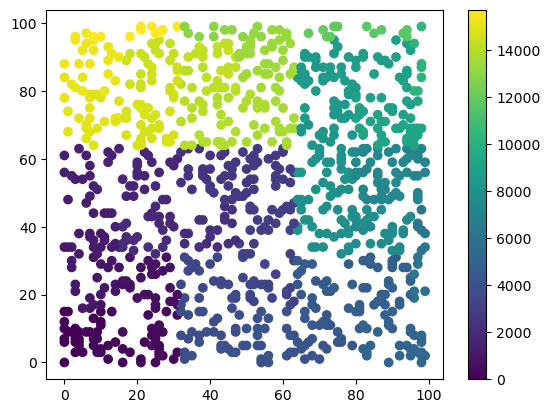

In [ ]:
hix = zarr.open('pc/hix.zarr','r')[:]
plt.scatter(gix[:,1], gix[:,0], c=hix)
plt.colorbar()
plt.show()

In [ ]:
#| export
@mc_logger
def pc_gix(
    hix:str, # grid index
    gix:str, # output, path
    shape:tuple, # (nlines, width)
):
    '''Compute the hillbert index from grid index for point cloud data.
    '''
    logger = logging.getLogger(__name__)
    hix_zarr = zarr.open(hix,'r'); logger.zarr_info(hix, hix_zarr)
    gix_zarr = zarr.open(gix, 'w', chunks=(hix_zarr.chunks[0],1), dtype=np.int32, shape=(hix_zarr.shape[0],2))
    logger.zarr_info(gix, gix_zarr)
    logger.info('calculating the grid index from hillbert index')
    gix_data = mr.pc_gix(hix_zarr[:],shape=shape)
    logger.info("writing the grid index")
    gix_zarr[:] = gix_data
    logger.info("done.")

In [ ]:
bbox = [0,0,100,100]
gix = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix.sort()
gix = np.stack(np.unravel_index(gix,shape=(100,100)),axis=-1).astype(np.int32)
gix_zarr = zarr.open('pc/gix.zarr','w',shape=gix.shape, chunks=(100,1),dtype=gix.dtype)
gix_zarr[:] = gix
pc_hix('pc/gix.zarr', 'pc/hix.zarr',shape=(100,100))
pc_gix('pc/hix.zarr','pc/gix_.zarr', (100,100))
np.testing.assert_array_equal(zarr.open('pc/gix_.zarr','r')[:], gix)

2025-06-24 21:42:08 - log_args - INFO - running function: pc_hix
2025-06-24 21:42:08 - log_args - INFO - fetching args:
2025-06-24 21:42:08 - log_args - INFO - gix = 'pc/gix.zarr'
2025-06-24 21:42:08 - log_args - INFO - hix = 'pc/hix.zarr'
2025-06-24 21:42:08 - log_args - INFO - shape = (100, 100)
2025-06-24 21:42:08 - log_args - INFO - fetching args done.
2025-06-24 21:42:08 - zarr_info - INFO - pc/gix.zarr zarray shape, chunks, dtype: (1000, 2), (100, 1), int32
2025-06-24 21:42:08 - zarr_info - INFO - pc/hix.zarr zarray shape, chunks, dtype: (1000,), (100,), int64
2025-06-24 21:42:08 - pc_hix - INFO - calculating the hillbert index based on grid index
2025-06-24 21:42:08 - pc_hix - INFO - writing the hillbert index
2025-06-24 21:42:08 - pc_hix - INFO - done.
2025-06-24 21:42:08 - log_args - INFO - running function: pc_gix
2025-06-24 21:42:08 - log_args - INFO - fetching args:
2025-06-24 21:42:08 - log_args - INFO - hix = 'pc/hix.zarr'
2025-06-24 21:42:08 - log_args - INFO - gix = 'pc

In [ ]:
#| export
@mc_logger
def pc_sort(
    idx_in:str, # the unsorted grid index or hillbert index of the input data
    idx:str, # output, the sorted grid index or hillbert index
    pc_in:str|list=None, # path (in string) or list of path for the input point cloud data
    pc:str|list=None, # output, path (in string) or list of path for the output point cloud data
    shape:tuple=None, # (nline, width), faster if provided for grid index input
    chunks:int=None, # chunk size in output data, same as `idx_in` by default
    key:str=None, #output, path (in string) for the key of sorting
    processes=False, # use process for dask worker or thread
    n_workers=1, # number of dask worker
    threads_per_worker=1, # number of threads per dask worker
    **dask_cluster_arg, # other dask local cluster args
):
    '''Sort point cloud data according to the indices that sort `idx_in`.
    '''
    idx_in_path = idx_in
    logger = logging.getLogger(__name__)
    idx_in_zarr = zarr.open(idx_in_path,mode='r'); logger.zarr_info(idx_in_path,idx_in_zarr)
    logger.info('loading idx_in and calculate the sorting indices.')
    idx_in = idx_in_zarr[:]; iidx = mr.pc_sort(idx_in, shape=shape)
    n_pc = idx_in_zarr.shape[0]
    if chunks is None: chunks = idx_in_zarr.chunks[0] 
    logger.info(f'output pc chunk size is {chunks}')
    idx_chunk_size = (chunks,1) if idx_in.ndim == 2 else (chunks,)
    idx_zarr = zarr.open(idx,'w', shape=idx_in_zarr.shape, dtype=idx_in.dtype, chunks=idx_chunk_size)
    logger.info('write idx'); logger.zarr_info('idx', idx_zarr)
    idx_zarr[:] = idx_in[iidx]
    if key is not None:
        logger.info('saving key for this sorting')
        key_zarr = zarr.open(key,'w',shape=iidx.shape,dtype=iidx.dtype,chunks=(chunks,))
        key_zarr[:] = iidx

    if pc_in is None:
        logger.info('no point cloud data provided, exit.')
        return None

    if isinstance(pc_in,str):
        assert isinstance(pc,str)
        pc_in_list = [pc_in]; pc_list = [pc]
    else:
        assert isinstance(pc_in,list); assert isinstance(pc,list)
        pc_in_list = pc_in; pc_list = pc

    logger.info('starting dask local cluster.')
    with LocalCluster(processes=processes, n_workers=n_workers, threads_per_worker=threads_per_worker,
                      **dask_cluster_arg) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')
        logger.dask_cluster_info(cluster)

        _pc_list = ()
        for pc_in_path, pc_path in zip(pc_in_list,pc_list):
            pc_in_zarr = zarr.open(pc_in_path,'r'); logger.zarr_info(pc_in_path, pc_in_zarr)
            pc_in = dask_from_zarr(pc_in_path,parallel_dims=0)
            logger.darr_info('pc_in', pc_in)
            logger.info('set up sorted pc data dask array.')
            pc = da.map_blocks(_indexing_pc_data, pc_in, iidx, chunks=pc_in.chunks, dtype=pc_in.dtype)
            logger.darr_info('pc',pc)
            logger.info(f'write pc to {pc_path}')
            _pc = dask_to_zarr(pc, pc_path, chunks=(chunks,*pc.chunksize[1:]))
            # _pc.visualize(filename=f'_pc.svg')
            _pc_list += (_pc,)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_pc_list)
        progress(futures,notebook=False)
        time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

In [ ]:
pc_in = np.random.rand(1000).astype(np.float32)
gix_in = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix_in = np.stack(np.unravel_index(gix_in,shape=(100,100)),axis=-1).astype(np.int32)
ind = np.lexsort((gix_in[:,1],gix_in[:,0]))
pc = pc_in[ind]; gix = gix_in[ind]

pc_in_zarr = zarr.open('pc/pc_in.zarr','w',shape=pc_in.shape,dtype=pc_in.dtype,chunks=(100,))
gix_in_zarr = zarr.open('pc/gix_in.zarr','w',shape=gix_in.shape,dtype=gix_in.dtype,chunks=(100,1))
pc_in_zarr[:] = pc_in; gix_in_zarr[:] = gix_in

In [ ]:
pc_sort('pc/gix_in.zarr','pc/gix.zarr','pc/pc_in.zarr','pc/pc.zarr',shape=(100,100))
pc_zarr = zarr.open('pc/pc.zarr','r'); gix_zarr = zarr.open('pc/gix.zarr','r')
np.testing.assert_array_equal(pc_zarr[:],pc)
np.testing.assert_array_equal(gix_zarr[:],gix)

2025-06-24 21:42:09 - log_args - INFO - running function: pc_sort
2025-06-24 21:42:09 - log_args - INFO - fetching args:
2025-06-24 21:42:09 - log_args - INFO - idx_in = 'pc/gix_in.zarr'
2025-06-24 21:42:09 - log_args - INFO - idx = 'pc/gix.zarr'
2025-06-24 21:42:09 - log_args - INFO - pc_in = 'pc/pc_in.zarr'
2025-06-24 21:42:09 - log_args - INFO - pc = 'pc/pc.zarr'
2025-06-24 21:42:09 - log_args - INFO - shape = (100, 100)
2025-06-24 21:42:09 - log_args - INFO - chunks = None
2025-06-24 21:42:09 - log_args - INFO - key = None
2025-06-24 21:42:09 - log_args - INFO - processes = False
2025-06-24 21:42:09 - log_args - INFO - n_workers = 1
2025-06-24 21:42:09 - log_args - INFO - threads_per_worker = 1
2025-06-24 21:42:09 - log_args - INFO - dask_cluster_arg = {}
2025-06-24 21:42:09 - log_args - INFO - fetching args done.
2025-06-24 21:42:09 - zarr_info - INFO - pc/gix_in.zarr zarray shape, chunks, dtype: (1000, 2), (100, 1), int32
2025-06-24 21:42:09 - pc_sort - INFO - loading idx_in and 

In [ ]:
pc_in = np.random.rand(1000).astype(np.float32)
hix_in = np.random.choice(np.arange(100*100,dtype=np.int64),size=1000,replace=False)
ind = np.argsort(hix_in,kind='stable')
pc = pc_in[ind]; hix = hix_in[ind]

pc_in_zarr = zarr.open('pc/pc_in.zarr','w',shape=pc_in.shape,dtype=pc_in.dtype,chunks=(100,))
hix_in_zarr = zarr.open('pc/hix_in.zarr','w',shape=hix_in.shape,dtype=hix_in.dtype,chunks=(100,))
pc_in_zarr[:] = pc_in; hix_in_zarr[:] = hix_in

pc_sort('pc/hix_in.zarr','pc/hix.zarr','pc/pc_in.zarr','pc/pc.zarr')
pc_zarr = zarr.open('pc/pc.zarr','r'); hix_zarr = zarr.open('pc/hix.zarr','r')
np.testing.assert_array_equal(pc_zarr[:],pc)
np.testing.assert_array_equal(hix_zarr[:],hix)

2025-06-24 21:42:10 - log_args - INFO - running function: pc_sort
2025-06-24 21:42:10 - log_args - INFO - fetching args:
2025-06-24 21:42:10 - log_args - INFO - idx_in = 'pc/hix_in.zarr'
2025-06-24 21:42:10 - log_args - INFO - idx = 'pc/hix.zarr'
2025-06-24 21:42:10 - log_args - INFO - pc_in = 'pc/pc_in.zarr'
2025-06-24 21:42:10 - log_args - INFO - pc = 'pc/pc.zarr'
2025-06-24 21:42:10 - log_args - INFO - shape = None
2025-06-24 21:42:10 - log_args - INFO - chunks = None
2025-06-24 21:42:10 - log_args - INFO - key = None
2025-06-24 21:42:10 - log_args - INFO - processes = False
2025-06-24 21:42:10 - log_args - INFO - n_workers = 1
2025-06-24 21:42:10 - log_args - INFO - threads_per_worker = 1
2025-06-24 21:42:10 - log_args - INFO - dask_cluster_arg = {}
2025-06-24 21:42:10 - log_args - INFO - fetching args done.
2025-06-24 21:42:10 - zarr_info - INFO - pc/hix_in.zarr zarray shape, chunks, dtype: (1000,), (100,), int64
2025-06-24 21:42:10 - pc_sort - INFO - loading idx_in and calculate 

In [ ]:
#| export
def _pc_union(pc1,pc2,inv_iidx1,inv_iidx2,iidx2,n_pc):
    pc = np.empty((n_pc,*pc1.shape[1:]),dtype=pc1.dtype)
    pc[inv_iidx1] = pc1
    pc[inv_iidx2] = pc2[iidx2]
    return pc

In [ ]:
#| export
@mc_logger
def pc_union(
    idx1:str, # grid index or hillbert index of the first point cloud
    idx2:str, # grid index or hillbert index of the second point cloud
    idx:str, # output, grid index or hillbert index of the union point cloud
    pc1:str|list=None, # path (in string) or list of path for the first point cloud data
    pc2:str|list=None, # path (in string) or list of path for the second point cloud data
    pc:str|list=None, #output, path (in string) or list of path for the union point cloud data
    shape:tuple=None, # image shape, faster if provided for grid index input
    chunks:int=None, # chunk size in output data, same as `idx1` by default
    processes=False, # use process for dask worker or thread
    n_workers=1, # number of dask worker
    threads_per_worker=1, # number of threads per dask worker
    **dask_cluster_arg, # other dask local cluster args
):
    '''Get the union of two point cloud dataset.
    For points at their intersection, pc_data1 rather than pc_data2 is copied to the result pc_data.
    `pc_chunk_size` and `n_pc_chunk` are used to determine the final pc_chunk_size.
    If non of them are provided, the pc_chunk_size is setted as it in idx1.
    '''
    logger = logging.getLogger(__name__)

    idx1_zarr = zarr.open(idx1,mode='r'); logger.zarr_info(idx1,idx1_zarr)
    idx2_zarr = zarr.open(idx2,mode='r'); logger.zarr_info(idx2,idx2_zarr)
    logger.info('loading idx1 and idx2 into memory.')
    idx1 = idx1_zarr[:]; idx2 = idx2_zarr[:]

    logger.info('calculate the union')
    idx_path = idx
    idx, inv_iidx1, inv_iidx2, iidx2 = mr.pc_union(idx1,idx2,shape=shape)
    n_pc = idx.shape[0]
    logger.info(f'number of points in the union: {n_pc}')
    if chunks is None: chunks = idx1_zarr.chunks[0] 
    idx_chunk_size = (chunks,1) if idx.ndim == 2 else (chunks,)
    idx_zarr = zarr.open(idx_path,'w',shape=idx.shape,dtype=idx.dtype,chunks=idx_chunk_size)
    logger.info('write union idx')
    idx_zarr[:] = idx
    logger.info('write done')
    logger.zarr_info(idx_path, idx_zarr)
    
    if pc1 is None:
        logger.info('no point cloud data provided, exit.')
        return None

    if isinstance(pc1,str):
        assert isinstance(pc2,str); assert isinstance(pc,str)
        pc1_list = [pc1]; pc2_list = [pc2]; pc_list = [pc]
    else:
        assert isinstance(pc1,list); assert isinstance(pc2,list); assert isinstance(pc,list)
        pc1_list = pc1; pc2_list = pc2; pc_list = pc

    logger.info('starting dask local cluster.')
    with LocalCluster(processes=processes, n_workers=n_workers, threads_per_worker=threads_per_worker,
                      **dask_cluster_arg) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')
        logger.dask_cluster_info(cluster)

        _pc_list = ()
        for pc1_path, pc2_path, pc_path in zip(pc1_list,pc2_list,pc_list):
            pc1_zarr = zarr.open(pc1_path,'r'); pc2_zarr = zarr.open(pc2_path,'r')
            logger.zarr_info(pc1_path, pc1_zarr); logger.zarr_info(pc2_path, pc2_zarr);
            pc1 = dask_from_zarr(pc1_path,parallel_dims=0)
            pc2 = dask_from_zarr(pc2_path,parallel_dims=0)
            logger.darr_info('pc1', pc1); logger.darr_info('pc2',pc2)
            logger.info('set up union pc data dask array.')
            pc = da.map_blocks(_pc_union, pc1,pc2,inv_iidx1,inv_iidx2,iidx2,n_pc, chunks=(n_pc,*pc1.chunks[1:]), dtype=pc1.dtype)
            logger.darr_info('pc',pc)
            logger.info(f'write pc to {pc_path}')
            _pc = dask_to_zarr(pc, pc_path, chunks=(chunks,*pc.chunksize[1:]))
            # pc.visualize(filename=f'pc.svg')
            _pc_list += (_pc,)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_pc_list)
        progress(futures,notebook=False); time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')

    logger.info('dask cluster closed.')

Usage:

In [ ]:
pc_data1 = np.random.rand(1000,3).astype(np.float32)+1j*np.random.rand(1000,3).astype(np.float32)
pc_data2 = np.random.rand(800,3).astype(np.float32)+1j*np.random.rand(800,3).astype(np.float32)

gix1 = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix1.sort()
gix1 = np.stack(np.unravel_index(gix1,shape=(100,100)),axis=-1).astype(np.int32)

gix2 = np.random.choice(np.arange(100*100,dtype=np.int32),size=800,replace=False)
gix2.sort()
gix2 = np.stack(np.unravel_index(gix2,shape=(100,100)),axis=-1).astype(np.int32)

gix, inv_iidx1, inv_iidx2, iidx2 = mr.pc_union(gix1,gix2)

pc_data = np.empty((gix.shape[0],*pc_data1.shape[1:]),dtype=pc_data1.dtype)
pc_data[inv_iidx1] = pc_data1
pc_data[inv_iidx2] = pc_data2[iidx2]

gix1_zarr = zarr.open('pc/gix1.zarr','w',shape=gix1.shape,dtype=gix1.dtype,chunks=(200,1))
gix2_zarr = zarr.open('pc/gix2.zarr','w',shape=gix2.shape,dtype=gix2.dtype,chunks=(200,1))
pc1_zarr = zarr.open('pc/pc1.zarr','w',shape=pc_data1.shape,dtype=pc_data1.dtype,chunks=(200,1))
pc2_zarr = zarr.open('pc/pc2.zarr','w',shape=pc_data2.shape,dtype=pc_data2.dtype,chunks=(200,1))
gix1_zarr[:] = gix1
gix2_zarr[:] = gix2
pc1_zarr[:] = pc_data1
pc2_zarr[:] = pc_data2

In [ ]:
pc_union('pc/gix1.zarr','pc/gix2.zarr','pc/gix.zarr', shape=(100,100))
pc_union('pc/gix1.zarr','pc/gix2.zarr','pc/gix.zarr','pc/pc1.zarr','pc/pc2.zarr','pc/pc.zarr')
gix_zarr = zarr.open('pc/gix.zarr','r')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(gix_zarr[:],gix)
np.testing.assert_array_equal(pc_zarr[:],pc_data)

2025-06-24 21:42:11 - log_args - INFO - running function: pc_union
2025-06-24 21:42:11 - log_args - INFO - fetching args:
2025-06-24 21:42:11 - log_args - INFO - idx1 = 'pc/gix1.zarr'
2025-06-24 21:42:11 - log_args - INFO - idx2 = 'pc/gix2.zarr'
2025-06-24 21:42:11 - log_args - INFO - idx = 'pc/gix.zarr'
2025-06-24 21:42:11 - log_args - INFO - pc1 = None
2025-06-24 21:42:11 - log_args - INFO - pc2 = None
2025-06-24 21:42:11 - log_args - INFO - pc = None
2025-06-24 21:42:11 - log_args - INFO - shape = (100, 100)
2025-06-24 21:42:11 - log_args - INFO - chunks = None
2025-06-24 21:42:11 - log_args - INFO - processes = False
2025-06-24 21:42:11 - log_args - INFO - n_workers = 1
2025-06-24 21:42:11 - log_args - INFO - threads_per_worker = 1
2025-06-24 21:42:11 - log_args - INFO - dask_cluster_arg = {}
2025-06-24 21:42:11 - log_args - INFO - fetching args done.
2025-06-24 21:42:11 - zarr_info - INFO - pc/gix1.zarr zarray shape, chunks, dtype: (1000, 2), (200, 1), int32
2025-06-24 21:42:11 - 

In [ ]:
pc_data1 = np.random.rand(1000,3).astype(np.float32)+1j*np.random.rand(1000,3).astype(np.float32)
pc_data2 = np.random.rand(800,3).astype(np.float32)+1j*np.random.rand(800,3).astype(np.float32)

hix1 = np.random.choice(np.arange(100*100,dtype=np.int64),size=1000,replace=False)
hix1.sort()

hix2 = np.random.choice(np.arange(100*100,dtype=np.int64),size=800,replace=False)
hix2.sort()

hix, inv_iidx1, inv_iidx2, iidx2 = mr.pc_union(hix1,hix2)

pc_data = np.empty((hix.shape[0],*pc_data1.shape[1:]),dtype=pc_data1.dtype)
pc_data[inv_iidx1] = pc_data1
pc_data[inv_iidx2] = pc_data2[iidx2]

hix1_zarr = zarr.open('pc/hix1.zarr','w',shape=hix1.shape,dtype=hix1.dtype,chunks=(200,))
hix2_zarr = zarr.open('pc/hix2.zarr','w',shape=hix2.shape,dtype=hix2.dtype,chunks=(200,))
pc1_zarr = zarr.open('pc/pc1.zarr','w',shape=pc_data1.shape,dtype=pc_data1.dtype,chunks=(200,1))
pc2_zarr = zarr.open('pc/pc2.zarr','w',shape=pc_data2.shape,dtype=pc_data2.dtype,chunks=(200,1))
hix1_zarr[:] = hix1
hix2_zarr[:] = hix2
pc1_zarr[:] = pc_data1
pc2_zarr[:] = pc_data2

In [ ]:
pc_union('pc/hix1.zarr','pc/hix2.zarr','pc/hix.zarr')
pc_union('pc/hix1.zarr','pc/hix2.zarr','pc/hix.zarr','pc/pc1.zarr','pc/pc2.zarr','pc/pc.zarr')
hix_zarr = zarr.open('pc/hix.zarr','r')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(hix_zarr[:],hix)
np.testing.assert_array_equal(pc_zarr[:],pc_data)

2025-06-24 21:42:12 - log_args - INFO - running function: pc_union
2025-06-24 21:42:12 - log_args - INFO - fetching args:
2025-06-24 21:42:12 - log_args - INFO - idx1 = 'pc/hix1.zarr'
2025-06-24 21:42:12 - log_args - INFO - idx2 = 'pc/hix2.zarr'
2025-06-24 21:42:12 - log_args - INFO - idx = 'pc/hix.zarr'
2025-06-24 21:42:12 - log_args - INFO - pc1 = None
2025-06-24 21:42:12 - log_args - INFO - pc2 = None
2025-06-24 21:42:12 - log_args - INFO - pc = None
2025-06-24 21:42:12 - log_args - INFO - shape = None
2025-06-24 21:42:12 - log_args - INFO - chunks = None
2025-06-24 21:42:12 - log_args - INFO - processes = False
2025-06-24 21:42:12 - log_args - INFO - n_workers = 1
2025-06-24 21:42:12 - log_args - INFO - threads_per_worker = 1
2025-06-24 21:42:12 - log_args - INFO - dask_cluster_arg = {}
2025-06-24 21:42:12 - log_args - INFO - fetching args done.
2025-06-24 21:42:12 - zarr_info - INFO - pc/hix1.zarr zarray shape, chunks, dtype: (1000,), (200,), int64
2025-06-24 21:42:12 - zarr_info 

In [ ]:
#| export
@mc_logger
def pc_intersect(
    idx1:str, # grid index or hillbert index of the first point cloud
    idx2:str, # grid index or hillbert index of the second point cloud
    idx:str, # output, grid index or hillbert index of the union point cloud
    pc1:str|list=None, # path (in string) or list of path for the first point cloud data
    pc2:str|list=None, # path (in string) or list of path for the second point cloud data
    pc:str|list=None, #output, path (in string) or list of path for the union point cloud data
    shape:tuple=None, # image shape, faster if provided for grid index input
    chunks:int=None, # chunk size in output data, same as `idx1` by default
    prefer_1=True, # save pc1 on intersection to output pc dataset by default `True`. Otherwise, save data from pc2
    processes=False, # use process for dask worker or thread
    n_workers=1, # number of dask worker
    threads_per_worker=1, # number of threads per dask worker
    **dask_cluster_arg, # other dask local cluster args
):
    '''Get the intersection of two point cloud dataset.
    `pc_chunk_size` and `n_pc_chunk` are used to determine the final pc_chunk_size.
    If non of them are provided, the n_pc_chunk is set to n_chunk in idx1.
    '''
    logger = logging.getLogger(__name__)

    idx1_zarr = zarr.open(idx1,mode='r'); logger.zarr_info(idx1,idx1_zarr)
    idx2_zarr = zarr.open(idx2,mode='r'); logger.zarr_info(idx2,idx2_zarr)
    logger.info('loading idx1 and idx2 into memory.')
    idx1 = idx1_zarr[:]; idx2 = idx2_zarr[:]

    logger.info('calculate the intersection')
    idx_path = idx
    idx, iidx1, iidx2 = mr.pc_intersect(idx1,idx2,shape=shape)
    n_pc = idx.shape[0]
    logger.info(f'number of points in the intersection: {n_pc}')
    if chunks is None: chunks = idx1_zarr.chunks[0] 
    idx_chunk_size = (chunks,1) if idx.ndim == 2 else (chunks,)    
    idx_zarr = zarr.open(idx_path,'w',shape=idx.shape,dtype=idx.dtype,chunks=idx_chunk_size)
    logger.info('write intersect idx')
    idx_zarr[:] = idx
    logger.info('write done')
    logger.zarr_info(idx_path, idx_zarr)

    if (pc1 is None) and (pc2 is None):
        logger.info('no point cloud data provided, exit.')
        return None

    if prefer_1:
        logger.info('select pc1 as pc_input.')
        iidx = iidx1; pc_input = pc1
    else:
        logger.info('select pc2 as pc_input.')
        iidx = iidx2; pc_input = pc2

    if isinstance(pc_input,str):
        assert isinstance(pc,str)
        pc_input_list = [pc_input]; pc_list = [pc]
    else:
        assert isinstance(pc_input,list); assert isinstance(pc,list)
        pc_input_list = pc_input; pc_list = pc

    logger.info('starting dask local cluster.')
    with LocalCluster(processes=processes, n_workers=n_workers, threads_per_worker=threads_per_worker,
                      **dask_cluster_arg) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')
        logger.dask_cluster_info(cluster)

        iidx_darr = da.from_array(iidx,chunks=iidx.shape)
        _pc_list = ()
        for pc_input_path, pc_path in zip(pc_input_list,pc_list):
            pc_input_zarr = zarr.open(pc_input_path,'r')
            logger.zarr_info(pc_input_path,pc_input_zarr)
            pc_input = dask_from_zarr(pc_input_path,parallel_dims=0)
            logger.darr_info('pc_input', pc_input)

            logger.info('set up intersect pc data dask array.')
            pc = da.map_blocks(_indexing_pc_data, pc_input, iidx_darr, chunks = (n_pc,*pc_input.chunks[1:]), dtype=pc_input.dtype)
            logger.darr_info('pc',pc)
            logger.info(f'write pc to {pc_path}')
            _pc = dask_to_zarr(pc,pc_path,chunks=(chunks,*pc.chunksize[1:]))
            #pc.visualize(filename=f'pc.svg')
            _pc_list += (_pc,)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_pc_list)
        progress(futures,notebook=False); time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

Usage:

In [ ]:
pc_data1 = np.random.rand(1000,3).astype(np.float32)+1j*np.random.rand(1000,3).astype(np.float32)
pc_data2 = np.random.rand(800,3).astype(np.float32)+1j*np.random.rand(800,3).astype(np.float32)

gix1 = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix1.sort()
gix1 = np.stack(np.unravel_index(gix1,shape=(100,100)),axis=-1).astype(np.int32)

gix2 = np.random.choice(np.arange(100*100,dtype=np.int32),size=800,replace=False)
gix2.sort()
gix2 = np.stack(np.unravel_index(gix2,shape=(100,100)),axis=-1).astype(np.int32)

gix, iidx1, iidx2 = mr.pc_intersect(gix1,gix2)

pc_data = np.empty((gix.shape[0],*pc_data1.shape[1:]),dtype=pc_data1.dtype)
pc_data[:] = pc_data2[iidx2]

gix1_zarr = zarr.open('pc/gix1.zarr','w',shape=gix1.shape,dtype=gix1.dtype,chunks=(200,1))
gix2_zarr = zarr.open('pc/gix2.zarr','w',shape=gix2.shape,dtype=gix2.dtype,chunks=(200,1))
pc1_zarr = zarr.open('pc/pc1.zarr','w',shape=pc_data1.shape,dtype=pc_data1.dtype,chunks=(200,1))
pc2_zarr = zarr.open('pc/pc2.zarr','w',shape=pc_data2.shape,dtype=pc_data2.dtype,chunks=(200,1))
gix1_zarr[:] = gix1
gix2_zarr[:] = gix2
pc1_zarr[:] = pc_data1
pc2_zarr[:] = pc_data2

In [ ]:
pc_intersect('pc/gix1.zarr','pc/gix2.zarr','pc/gix.zarr', shape=(100,100))
pc_intersect('pc/gix1.zarr','pc/gix2.zarr','pc/gix.zarr',pc2='pc/pc2.zarr', pc='pc/pc.zarr',prefer_1=False)
gix_zarr = zarr.open('pc/gix.zarr','r')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(gix_zarr[:],gix)
np.testing.assert_array_equal(pc_zarr[:],pc_data)

2025-06-24 21:42:13 - log_args - INFO - running function: pc_intersect
2025-06-24 21:42:13 - log_args - INFO - fetching args:
2025-06-24 21:42:13 - log_args - INFO - idx1 = 'pc/gix1.zarr'
2025-06-24 21:42:13 - log_args - INFO - idx2 = 'pc/gix2.zarr'
2025-06-24 21:42:13 - log_args - INFO - idx = 'pc/gix.zarr'
2025-06-24 21:42:13 - log_args - INFO - pc1 = None
2025-06-24 21:42:13 - log_args - INFO - pc2 = None
2025-06-24 21:42:13 - log_args - INFO - pc = None
2025-06-24 21:42:13 - log_args - INFO - shape = (100, 100)
2025-06-24 21:42:13 - log_args - INFO - chunks = None
2025-06-24 21:42:13 - log_args - INFO - prefer_1 = True
2025-06-24 21:42:13 - log_args - INFO - processes = False
2025-06-24 21:42:13 - log_args - INFO - n_workers = 1
2025-06-24 21:42:13 - log_args - INFO - threads_per_worker = 1
2025-06-24 21:42:13 - log_args - INFO - dask_cluster_arg = {}
2025-06-24 21:42:13 - log_args - INFO - fetching args done.
2025-06-24 21:42:13 - zarr_info - INFO - pc/gix1.zarr zarray shape, chun

In [ ]:
pc_data1 = np.random.rand(1000,3).astype(np.float32)+1j*np.random.rand(1000,3).astype(np.float32)
pc_data2 = np.random.rand(800,3).astype(np.float32)+1j*np.random.rand(800,3).astype(np.float32)

hix1 = np.random.choice(np.arange(100*100,dtype=np.int64),size=1000,replace=False)
hix1.sort()

hix2 = np.random.choice(np.arange(100*100,dtype=np.int64),size=800,replace=False)
hix2.sort()

hix, iidx1, iidx2 = mr.pc_intersect(hix1,hix2)

pc_data = np.empty((hix.shape[-1],*pc_data1.shape[1:]),dtype=pc_data1.dtype)
pc_data[:] = pc_data2[iidx2]

hix1_zarr = zarr.open('pc/hix1.zarr','w',shape=hix1.shape,dtype=hix1.dtype,chunks=(200,))
hix2_zarr = zarr.open('pc/hix2.zarr','w',shape=hix2.shape,dtype=hix2.dtype,chunks=(200,))
pc1_zarr = zarr.open('pc/pc1.zarr','w',shape=pc_data1.shape,dtype=pc_data1.dtype,chunks=(200,1))
pc2_zarr = zarr.open('pc/pc2.zarr','w',shape=pc_data2.shape,dtype=pc_data2.dtype,chunks=(200,1))
hix1_zarr[:] = hix1
hix2_zarr[:] = hix2
pc1_zarr[:] = pc_data1
pc2_zarr[:] = pc_data2

In [ ]:
pc_intersect('pc/hix1.zarr','pc/hix2.zarr','pc/hix.zarr')
pc_intersect('pc/hix1.zarr','pc/hix2.zarr','pc/hix.zarr',pc2='pc/pc2.zarr', pc='pc/pc.zarr',prefer_1=False)
hix_zarr = zarr.open('pc/hix.zarr','r')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(hix_zarr[:],hix)
np.testing.assert_array_equal(pc_zarr[:],pc_data)

2025-06-24 21:42:14 - log_args - INFO - running function: pc_intersect
2025-06-24 21:42:14 - log_args - INFO - fetching args:
2025-06-24 21:42:14 - log_args - INFO - idx1 = 'pc/hix1.zarr'
2025-06-24 21:42:14 - log_args - INFO - idx2 = 'pc/hix2.zarr'
2025-06-24 21:42:14 - log_args - INFO - idx = 'pc/hix.zarr'
2025-06-24 21:42:14 - log_args - INFO - pc1 = None
2025-06-24 21:42:14 - log_args - INFO - pc2 = None
2025-06-24 21:42:14 - log_args - INFO - pc = None
2025-06-24 21:42:14 - log_args - INFO - shape = None
2025-06-24 21:42:14 - log_args - INFO - chunks = None
2025-06-24 21:42:14 - log_args - INFO - prefer_1 = True
2025-06-24 21:42:14 - log_args - INFO - processes = False
2025-06-24 21:42:14 - log_args - INFO - n_workers = 1
2025-06-24 21:42:14 - log_args - INFO - threads_per_worker = 1
2025-06-24 21:42:14 - log_args - INFO - dask_cluster_arg = {}
2025-06-24 21:42:14 - log_args - INFO - fetching args done.
2025-06-24 21:42:14 - zarr_info - INFO - pc/hix1.zarr zarray shape, chunks, dt

In [ ]:
#| export
@mc_logger
def pc_diff(
    idx1:str, # grid index or hillbert index of the first point cloud
    idx2:str, # grid index or hillbert index of the second point cloud
    idx:str, # output, grid index or hillbert index of the union point cloud
    pc1:str|list=None, # path (in string) or list of path for the first point cloud data
    pc:str|list=None, #output, path (in string) or list of path for the union point cloud data
    shape:tuple=None, # image shape, faster if provided for grid index input
    chunks:int=None, # chunk size in output data,optional
    processes=False, # use process for dask worker or thread
    n_workers=1, # number of dask worker
    threads_per_worker=1, # number of threads per dask worker
    **dask_cluster_arg, # other dask local cluster args
           ):
    '''Get the point cloud in `idx1` that are not in `idx2`.
    `pc_chunk_size` and `n_pc_chunk` are used to determine the final pc_chunk_size.
    If non of them are provided, the n_pc_chunk is set to n_chunk in idx1.
    '''
    logger = logging.getLogger(__name__)

    idx1_zarr = zarr.open(idx1,mode='r'); logger.zarr_info(idx1,idx1_zarr)
    idx2_zarr = zarr.open(idx2,mode='r'); logger.zarr_info(idx2,idx2_zarr)
    logger.info('loading idx1 and idx2 into memory.')
    idx1 = idx1_zarr[:]; idx2 = idx2_zarr[:]

    logger.info('calculate the diff.')
    idx_path = idx
    idx, iidx1 = mr.pc_diff(idx1,idx2,shape=shape)
    n_pc = idx.shape[0]
    logger.info(f'number of points in the diff: {n_pc}')
    if chunks is None: chunks = idx1_zarr.chunks[0] 
    idx_chunk_size = (chunks,1) if idx.ndim == 2 else (chunks,)
    idx_zarr = zarr.open(idx_path,'w',shape=idx.shape,dtype=idx.dtype,chunks=idx_chunk_size)
    logger.info('write intersect idx')
    idx_zarr[:] = idx
    logger.info('write done')
    logger.zarr_info(idx_path, idx_zarr)

    if pc1 is None:
        logger.info('no point cloud data provided, exit.')
        return None

    if isinstance(pc1,str):
        assert isinstance(pc,str)
        pc1_list = [pc1]; pc_list = [pc]
    else:
        assert isinstance(pc1,list); assert isinstance(pc,list)
        pc1_list = pc1; pc_list = pc

    logger.info('starting dask local cluster.')
    with LocalCluster(processes=processes,n_workers=n_workers, threads_per_worker=threads_per_worker,
                     **dask_cluster_arg) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')
        logger.dask_cluster_info(cluster)
        
        iidx1_darr = da.from_array(iidx1,chunks=iidx1.shape)

        _pc_list = ()
        for pc1_path, pc_path in zip(pc1_list,pc_list):
            pc1_zarr = zarr.open(pc1_path,'r'); logger.zarr_info(pc1_path, pc1_zarr)
            pc1 = dask_from_zarr(pc1_path,parallel_dims=0); logger.darr_info('pc1', pc1)
            logger.info('set up diff pc data dask array.')
            pc = da.map_blocks(_indexing_pc_data, pc1, iidx1_darr, chunks = (n_pc,*pc1.chunks[1:]), dtype=pc1.dtype)
            logger.darr_info('pc',pc)

            logger.info(f'write pc to {pc_path}')
            _pc = dask_to_zarr(pc,pc_path,chunks=(chunks,*pc.chunksize[1:]))
            # pc.visualize(filename=f'pc.svg',optimize_graph=True)
            _pc_list += (_pc,)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_pc_list)
        progress(futures,notebook=False); time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

Usage:

In [ ]:
pc_data1 = np.random.rand(1000,3).astype(np.float32)+1j*np.random.rand(1000,3).astype(np.float32)

gix1 = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix1.sort()
gix1 = np.stack(np.unravel_index(gix1,shape=(100,100)),axis=-1).astype(np.int32)

gix2 = np.random.choice(np.arange(100*100,dtype=np.int32),size=800,replace=False)
gix2.sort()
gix2 = np.stack(np.unravel_index(gix2,shape=(100,100)),axis=-1).astype(np.int32)

gix, iidx1 = mr.pc_diff(gix1,gix2)

pc_data = np.empty((gix.shape[0],*pc_data1.shape[1:]),dtype=pc_data1.dtype)
pc_data[:] = pc_data1[iidx1]

gix1_zarr = zarr.open('pc/gix1.zarr','w',shape=gix1.shape,dtype=gix1.dtype,chunks=(200,1))
gix2_zarr = zarr.open('pc/gix2.zarr','w',shape=gix2.shape,dtype=gix2.dtype,chunks=(200,1))
pc1_zarr = zarr.open('pc/pc1.zarr','w',shape=pc_data1.shape,dtype=pc_data1.dtype,chunks=(200,1))
gix1_zarr[:] = gix1
gix2_zarr[:] = gix2
pc1_zarr[:] = pc_data1

In [ ]:
pc_diff('pc/gix1.zarr','pc/gix2.zarr','pc/gix.zarr')
pc_diff('pc/gix1.zarr','pc/gix2.zarr','pc/gix.zarr',pc1='pc/pc1.zarr', pc='pc/pc.zarr')
gix_zarr = zarr.open('pc/gix.zarr','r')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(gix_zarr[:],gix)
np.testing.assert_array_equal(pc_zarr[:],pc_data)

2025-06-24 21:42:14 - log_args - INFO - running function: pc_diff
2025-06-24 21:42:14 - log_args - INFO - fetching args:
2025-06-24 21:42:14 - log_args - INFO - idx1 = 'pc/gix1.zarr'
2025-06-24 21:42:14 - log_args - INFO - idx2 = 'pc/gix2.zarr'
2025-06-24 21:42:14 - log_args - INFO - idx = 'pc/gix.zarr'
2025-06-24 21:42:14 - log_args - INFO - pc1 = None
2025-06-24 21:42:14 - log_args - INFO - pc = None
2025-06-24 21:42:14 - log_args - INFO - shape = None
2025-06-24 21:42:14 - log_args - INFO - chunks = None
2025-06-24 21:42:14 - log_args - INFO - processes = False
2025-06-24 21:42:14 - log_args - INFO - n_workers = 1
2025-06-24 21:42:14 - log_args - INFO - threads_per_worker = 1
2025-06-24 21:42:14 - log_args - INFO - dask_cluster_arg = {}
2025-06-24 21:42:14 - log_args - INFO - fetching args done.
2025-06-24 21:42:14 - zarr_info - INFO - pc/gix1.zarr zarray shape, chunks, dtype: (1000, 2), (200, 1), int32
2025-06-24 21:42:14 - zarr_info - INFO - pc/gix2.zarr zarray shape, chunks, dtyp

In [ ]:
pc_data1 = np.random.rand(1000,3).astype(np.float32)+1j*np.random.rand(1000,3).astype(np.float32)

hix1 = np.random.choice(np.arange(100*100,dtype=np.int64),size=1000,replace=False)
hix1.sort()

hix2 = np.random.choice(np.arange(100*100,dtype=np.int64),size=800,replace=False)
hix2.sort()

hix, iidx1 = mr.pc_diff(hix1,hix2)

pc_data = np.empty((hix.shape[-1],*pc_data1.shape[1:]),dtype=pc_data1.dtype)
pc_data[:] = pc_data1[iidx1]

hix1_zarr = zarr.open('pc/hix1.zarr','w',shape=hix1.shape,dtype=hix1.dtype,chunks=(200,))
hix2_zarr = zarr.open('pc/hix2.zarr','w',shape=hix2.shape,dtype=hix2.dtype,chunks=(200,))
pc1_zarr = zarr.open('pc/pc1.zarr','w',shape=pc_data1.shape,dtype=pc_data1.dtype,chunks=(200,1))
hix1_zarr[:] = hix1
hix2_zarr[:] = hix2
pc1_zarr[:] = pc_data1

In [ ]:
pc_diff('pc/hix1.zarr','pc/hix2.zarr','pc/hix.zarr')
pc_diff('pc/hix1.zarr','pc/hix2.zarr','pc/hix.zarr',pc1='pc/pc1.zarr', pc='pc/pc.zarr')
hix_zarr = zarr.open('pc/hix.zarr','r')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(hix_zarr[:],hix)
np.testing.assert_array_equal(pc_zarr[:],pc_data)

2025-06-24 21:42:15 - log_args - INFO - running function: pc_diff
2025-06-24 21:42:15 - log_args - INFO - fetching args:
2025-06-24 21:42:15 - log_args - INFO - idx1 = 'pc/hix1.zarr'
2025-06-24 21:42:15 - log_args - INFO - idx2 = 'pc/hix2.zarr'
2025-06-24 21:42:15 - log_args - INFO - idx = 'pc/hix.zarr'
2025-06-24 21:42:15 - log_args - INFO - pc1 = None
2025-06-24 21:42:15 - log_args - INFO - pc = None
2025-06-24 21:42:15 - log_args - INFO - shape = None
2025-06-24 21:42:15 - log_args - INFO - chunks = None
2025-06-24 21:42:15 - log_args - INFO - processes = False
2025-06-24 21:42:15 - log_args - INFO - n_workers = 1
2025-06-24 21:42:15 - log_args - INFO - threads_per_worker = 1
2025-06-24 21:42:15 - log_args - INFO - dask_cluster_arg = {}
2025-06-24 21:42:15 - log_args - INFO - fetching args done.
2025-06-24 21:42:15 - zarr_info - INFO - pc/hix1.zarr zarray shape, chunks, dtype: (1000,), (200,), int64
2025-06-24 21:42:15 - zarr_info - INFO - pc/hix2.zarr zarray shape, chunks, dtype: (

In [ ]:
#| export
@mc_logger
def pc_logic_ras(ras, # the raster image used for thresholding
                 gix, # output, grid index of selected pixels
                 operation:str, # logical operation on input ras
                 chunks:int=100000, # chunk size in output data, optional
                ):
    '''generate point cloud index based on logical operation of one raster image.
    '''
    gix_path = gix
    logger = logging.getLogger(__name__)
    ras_zarr = zarr.open(ras, mode='r'); logger.zarr_info(ras,ras_zarr)

    ras = ras_zarr[:]; logger.info('loading ras into memory.')
    is_pc = ne.evaluate(operation,{'ras':ras})
    logger.info(f'select pc based on operation: {operation}')
    gix = np.stack(np.where(is_pc),axis=-1).astype(np.int32)
    n_pc = gix.shape[0]
    logger.info(f'number of selected pixels: {n_pc}.')

    gix_zarr = zarr.open(gix_path,'w',dtype=gix.dtype,shape=gix.shape,chunks=(chunks,1))
    logger.zarr_info(gix_path, gix_zarr)
    logger.info('writing gix.')
    gix_zarr[:] = gix
    logger.info('write done.')

In [ ]:
ras = np.random.rand(100,100).astype(np.float32)
min_thres = 0.1; max_thres=0.5
is_pc = (ras>=min_thres) & (ras<=max_thres)
gix = np.stack(np.where(is_pc),axis=-1).astype(np.int32)
ras_zarr = zarr.open('pc/ras.zarr','w',shape=ras.shape,dtype=ras.dtype,chunks=(10,100))
ras_zarr[:] = ras

In [ ]:
pc_logic_ras('pc/ras.zarr','pc/gix.zarr',f'(ras>={min_thres})&(ras<={max_thres})')
gix_zarr = zarr.open('pc/gix.zarr','r')
np.testing.assert_array_equal(gix_zarr[:],gix)

2025-06-24 21:44:13 - log_args - INFO - running function: pc_logic_ras
2025-06-24 21:44:13 - log_args - INFO - fetching args:
2025-06-24 21:44:13 - log_args - INFO - ras = 'pc/ras.zarr'
2025-06-24 21:44:13 - log_args - INFO - gix = 'pc/gix.zarr'
2025-06-24 21:44:13 - log_args - INFO - operation = '(ras>=0.1)&(ras<=0.5)'
2025-06-24 21:44:13 - log_args - INFO - chunks = 100000
2025-06-24 21:44:13 - log_args - INFO - fetching args done.
2025-06-24 21:44:13 - zarr_info - INFO - pc/ras.zarr zarray shape, chunks, dtype: (100, 100), (10, 100), float32
2025-06-24 21:44:13 - pc_logic_ras - INFO - loading ras into memory.
2025-06-24 21:44:13 - pc_logic_ras - INFO - select pc based on operation: (ras>=0.1)&(ras<=0.5)
2025-06-24 21:44:13 - pc_logic_ras - INFO - number of selected pixels: 3997.
2025-06-24 21:44:13 - zarr_info - INFO - pc/gix.zarr zarray shape, chunks, dtype: (3997, 2), (100000, 1), int32
2025-06-24 21:44:13 - pc_logic_ras - INFO - writing gix.
2025-06-24 21:44:13 - pc_logic_ras - I

In [ ]:
#| export
@mc_logger
def pc_logic_pc(idx_in:str,# the grid index or hillbert index of input pc data
                pc_in:str, # the grid index or hillbert index cloud data used for thresholding
                idx:str, # output, grid index or hillbert index of selected pixels
                operation:str, # operator
                chunks:int=None, # chunk size in output data,optional
               ):
    '''generate point cloud index and data based on logical operation one point cloud data.
    '''
    idx_path = idx
    logger = logging.getLogger(__name__)
    idx_in_zarr = zarr.open(idx_in,mode='r'); logger.zarr_info(idx_in,idx_in_zarr)
    pc_in_zarr = zarr.open(pc_in, mode='r'); logger.zarr_info(pc_in,pc_in_zarr)

    idx_in = idx_in_zarr[:]; logger.info('loading idx_in into memory.')
    pc_in = pc_in_zarr[:]; logger.info('loading pc_in into memory.')

    is_pc = ne.evaluate(operation,{'pc_in':pc_in})
    logger.info(f'select pc based on operation: {operation}')
    idx = idx_in[is_pc]
    n_pc = idx.shape[0]
    logger.info(f'number of selected pixels: {n_pc}.')
    if chunks is None: chunks = idx_in_zarr.chunks[0] 
    idx_chunk_size = (chunks,1) if idx.ndim == 2 else (chunks,)
    idx_zarr = zarr.open(idx_path,'w',shape=idx.shape,dtype=idx.dtype,chunks=idx_chunk_size)
    logger.zarr_info('idx', idx_zarr)
    logger.info('writing idx.')
    idx_zarr[:] = idx
    logger.info('write done.')

Usage:

In [ ]:
pc_in = np.random.rand(1000).astype(np.float32)
gix_in = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix_in.sort()
gix_in = np.stack(np.unravel_index(gix_in,shape=(100,100)),axis=-1).astype(np.int32)

min_thres = 0.1; max_thres=0.5
is_pc = (pc_in>=min_thres) & (pc_in<=max_thres)
gix = gix_in[is_pc]
pc_in_zarr = zarr.open('pc/pc_in.zarr','w',shape=pc_in.shape,dtype=pc_in.dtype,chunks=(100,))
gix_in_zarr = zarr.open('pc/gix_in.zarr','w',shape=gix_in.shape,dtype=gix_in.dtype,chunks=(100,1))
pc_in_zarr[:] = pc_in; gix_in_zarr[:] = gix_in

In [ ]:
pc_logic_pc('pc/gix_in.zarr','pc/pc_in.zarr','pc/gix.zarr',f'(pc_in>={min_thres})&(pc_in<={max_thres})')
gix_zarr = zarr.open('pc/gix.zarr','r')
np.testing.assert_array_equal(gix_zarr[:],gix)

2025-06-24 21:44:21 - log_args - INFO - running function: pc_logic_pc
2025-06-24 21:44:21 - log_args - INFO - fetching args:
2025-06-24 21:44:21 - log_args - INFO - idx_in = 'pc/gix_in.zarr'
2025-06-24 21:44:21 - log_args - INFO - pc_in = 'pc/pc_in.zarr'
2025-06-24 21:44:21 - log_args - INFO - idx = 'pc/gix.zarr'
2025-06-24 21:44:21 - log_args - INFO - operation = '(pc_in>=0.1)&(pc_in<=0.5)'
2025-06-24 21:44:21 - log_args - INFO - chunks = None
2025-06-24 21:44:21 - log_args - INFO - fetching args done.
2025-06-24 21:44:21 - zarr_info - INFO - pc/gix_in.zarr zarray shape, chunks, dtype: (1000, 2), (100, 1), int32
2025-06-24 21:44:21 - zarr_info - INFO - pc/pc_in.zarr zarray shape, chunks, dtype: (1000,), (100,), float32
2025-06-24 21:44:21 - pc_logic_pc - INFO - loading idx_in into memory.
2025-06-24 21:44:21 - pc_logic_pc - INFO - loading pc_in into memory.
2025-06-24 21:44:21 - pc_logic_pc - INFO - select pc based on operation: (pc_in>=0.1)&(pc_in<=0.5)
2025-06-24 21:44:21 - pc_logic

In [ ]:
pc_in = np.random.rand(1000).astype(np.float32)
hix_in = np.random.choice(np.arange(100*100,dtype=np.int64),size=1000,replace=False)
hix_in.sort()

min_thres = 0.1; max_thres=0.5
is_pc = (pc_in>=min_thres) & (pc_in<=max_thres)
hix = hix_in[is_pc]
pc_in_zarr = zarr.open('pc/pc_in.zarr','w',shape=pc_in.shape,dtype=pc_in.dtype,chunks=(100,))
hix_in_zarr = zarr.open('pc/hix_in.zarr','w',shape=hix_in.shape,dtype=hix_in.dtype,chunks=(100,))
pc_in_zarr[:] = pc_in; hix_in_zarr[:] = hix_in

pc_logic_pc('pc/hix_in.zarr','pc/pc_in.zarr','pc/hix.zarr',f'(pc_in>={min_thres})&(pc_in<={max_thres})')
hix_zarr = zarr.open('pc/hix.zarr','r')
np.testing.assert_array_equal(hix_zarr[:],hix)

2025-06-24 21:44:21 - log_args - INFO - running function: pc_logic_pc
2025-06-24 21:44:21 - log_args - INFO - fetching args:
2025-06-24 21:44:21 - log_args - INFO - idx_in = 'pc/hix_in.zarr'
2025-06-24 21:44:21 - log_args - INFO - pc_in = 'pc/pc_in.zarr'
2025-06-24 21:44:21 - log_args - INFO - idx = 'pc/hix.zarr'
2025-06-24 21:44:21 - log_args - INFO - operation = '(pc_in>=0.1)&(pc_in<=0.5)'
2025-06-24 21:44:21 - log_args - INFO - chunks = None
2025-06-24 21:44:21 - log_args - INFO - fetching args done.
2025-06-24 21:44:21 - zarr_info - INFO - pc/hix_in.zarr zarray shape, chunks, dtype: (1000,), (100,), int64
2025-06-24 21:44:21 - zarr_info - INFO - pc/pc_in.zarr zarray shape, chunks, dtype: (1000,), (100,), float32
2025-06-24 21:44:21 - pc_logic_pc - INFO - loading idx_in into memory.
2025-06-24 21:44:21 - pc_logic_pc - INFO - loading pc_in into memory.
2025-06-24 21:44:21 - pc_logic_pc - INFO - select pc based on operation: (pc_in>=0.1)&(pc_in<=0.5)
2025-06-24 21:44:21 - pc_logic_pc 

In [ ]:
#| export
@mc_logger
def pc_select_data(
    idx_in:str, # the grid index or hillbert index of the input data
    idx:str, # the grid index or hillbert index of the output data
    pc_in:str|list, # path (in string) or list of path for the input point cloud data
    pc:str|list, # output, path (in string) or list of path for the output point cloud data
    shape:tuple=None, # shape of the raster data the point cloud from, must be provided if `idx` is hix
    chunks:int=None, # chunk size in output data, same as chunks of `idx` by default
    processes=False, # use process for dask worker or thread
    n_workers=1, # number of dask worker
    threads_per_worker=1, # number of threads per dask worker
    **dask_cluster_arg, # other dask local cluster args
):
    '''generate point cloud data based on its index and one point cloud data.
    The index of generated point cloud data must in the index of the old one.
    '''
    idx_in_path = idx_in; idx_path = idx
    logger = logging.getLogger(__name__)
    idx_in_zarr = zarr.open(idx_in_path,mode='r'); logger.zarr_info(idx_in_path,idx_in_zarr)
    idx_zarr = zarr.open(idx_path,mode='r'); logger.zarr_info(idx_path,idx_zarr)
    logger.info('loading idx_in and idx into memory.')
    idx_in = idx_in_zarr[:]; idx = idx_zarr[:]
    if idx_in.ndim == idx.ndim:
        iidx_in, iidx = mr.pc_intersect(idx_in,idx,shape)[1:]
    elif (idx_in.ndim == 2) and (idx.ndim == 1):
        hix_in_unsorted = mr.pc_hix(idx_in, shape)
        iidx_in, iidx = np.intersect1d(hix_in_unsorted, idx, assume_unique=True, return_indices=True)[1:]
    else:
        raise NotImplementedError('idx_in as hilbert index while idx as grid index have not been supported yet.')
    np.testing.assert_array_equal(iidx,np.arange(iidx.shape[0]),err_msg='idx have points that are not covered by idx_in.')
    n_pc = iidx_in.shape[0]
    if chunks is None: chunks = idx_zarr.chunks[0] 

    if isinstance(pc_in,str):
        assert isinstance(pc,str)
        pc_in_list = [pc_in]; pc_list = [pc]
    else:
        assert isinstance(pc_in,list); assert isinstance(pc,list)
        pc_in_list = pc_in; pc_list = pc

    logger.info('starting dask local cluster.')
    with LocalCluster(processes=processes, n_workers=n_workers, threads_per_worker=threads_per_worker,
                      **dask_cluster_arg) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')
        logger.dask_cluster_info(cluster)

        iidx_in_darr = da.from_array(iidx_in,chunks=iidx_in.shape)

        _pc_list = ()
        for pc_in_path, pc_path in zip(pc_in_list,pc_list):
            pc_in_zarr = zarr.open(pc_in_path,'r'); logger.zarr_info(pc_in_path, pc_in_zarr)
            pc_in = dask_from_zarr(pc_in_path,parallel_dims=0); logger.darr_info('pc_in', pc_in)
            logger.info('set up selected pc data dask array.')
            pc = da.map_blocks(_indexing_pc_data, pc_in, iidx_in_darr, chunks = (n_pc, *pc_in.chunks[1:]), dtype=pc_in.dtype)
            logger.darr_info('pc',pc)
            logger.info(f'write pc to {pc_path}')
            _pc = dask_to_zarr(pc,pc_path,chunks=(chunks,*pc.chunksize[1:]))
            _pc_list += (_pc,)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_pc_list)
        progress(futures,notebook=False); time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

In [ ]:
pc_in = np.random.rand(1000,4).astype(np.float32)
gix_in = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix_in.sort()
gix_in = np.stack(np.unravel_index(gix_in,shape=(100,100)),axis=-1).astype(np.int32)

iidx_in = np.random.choice(np.arange(1000,dtype=np.int64),size=500,replace=False); iidx_in.sort()
gix = gix_in[iidx_in]
pc = pc_in[iidx_in]

pc_in_zarr = zarr.open('pc/pc_in.zarr','w',shape=pc_in.shape,dtype=pc_in.dtype,chunks=(100,1))
gix_in_zarr = zarr.open('pc/gix_in.zarr','w',shape=gix_in.shape,dtype=gix_in.dtype,chunks=(100,1))
gix_zarr = zarr.open('pc/gix.zarr','w',shape=gix.shape,dtype=gix.dtype,chunks=(100,1))
pc_in_zarr[:] = pc_in; gix_in_zarr[:] = gix_in; gix_zarr[:] = gix

In [ ]:
pc_select_data('pc/gix_in.zarr','pc/gix.zarr','pc/pc_in.zarr','pc/pc.zarr')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(pc_zarr[:],pc)

2025-06-24 21:44:23 - log_args - INFO - running function: pc_select_data
2025-06-24 21:44:23 - log_args - INFO - fetching args:
2025-06-24 21:44:23 - log_args - INFO - idx_in = 'pc/gix_in.zarr'
2025-06-24 21:44:23 - log_args - INFO - idx = 'pc/gix.zarr'
2025-06-24 21:44:23 - log_args - INFO - pc_in = 'pc/pc_in.zarr'
2025-06-24 21:44:23 - log_args - INFO - pc = 'pc/pc.zarr'
2025-06-24 21:44:23 - log_args - INFO - shape = None
2025-06-24 21:44:23 - log_args - INFO - chunks = None
2025-06-24 21:44:23 - log_args - INFO - processes = False
2025-06-24 21:44:23 - log_args - INFO - n_workers = 1
2025-06-24 21:44:23 - log_args - INFO - threads_per_worker = 1
2025-06-24 21:44:23 - log_args - INFO - dask_cluster_arg = {}
2025-06-24 21:44:23 - log_args - INFO - fetching args done.
2025-06-24 21:44:23 - zarr_info - INFO - pc/gix_in.zarr zarray shape, chunks, dtype: (1000, 2), (100, 1), int32
2025-06-24 21:44:23 - zarr_info - INFO - pc/gix.zarr zarray shape, chunks, dtype: (500, 2), (100, 1), int32


In [ ]:
pc_in = np.random.rand(1000).astype(np.float32)
hix_in = np.random.choice(np.arange(100*100,dtype=np.int64),size=1000,replace=False)
hix_in.sort()

iidx_in = np.random.choice(np.arange(1000,dtype=np.int64),size=500,replace=False)
iidx_in.sort()

hix = hix_in[iidx_in]
pc = pc_in[iidx_in]

pc_in_zarr = zarr.open('pc/pc_in.zarr','w',shape=pc_in.shape,dtype=pc_in.dtype,chunks=(100,))
hix_in_zarr = zarr.open('pc/hix_in.zarr','w',shape=hix_in.shape,dtype=hix_in.dtype,chunks=(100,))
hix_zarr = zarr.open('pc/hix.zarr','w',shape=hix.shape,dtype=hix.dtype,chunks=(100,))
pc_in_zarr[:] = pc_in; hix_in_zarr[:] = hix_in; hix_zarr[:] = hix

pc_select_data('pc/hix_in.zarr','pc/hix.zarr','pc/pc_in.zarr','pc/pc.zarr')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(pc_zarr[:],pc)

2025-06-24 21:44:23 - log_args - INFO - running function: pc_select_data
2025-06-24 21:44:23 - log_args - INFO - fetching args:
2025-06-24 21:44:23 - log_args - INFO - idx_in = 'pc/hix_in.zarr'
2025-06-24 21:44:23 - log_args - INFO - idx = 'pc/hix.zarr'
2025-06-24 21:44:23 - log_args - INFO - pc_in = 'pc/pc_in.zarr'
2025-06-24 21:44:23 - log_args - INFO - pc = 'pc/pc.zarr'
2025-06-24 21:44:23 - log_args - INFO - shape = None
2025-06-24 21:44:23 - log_args - INFO - chunks = None
2025-06-24 21:44:23 - log_args - INFO - processes = False
2025-06-24 21:44:23 - log_args - INFO - n_workers = 1
2025-06-24 21:44:23 - log_args - INFO - threads_per_worker = 1
2025-06-24 21:44:23 - log_args - INFO - dask_cluster_arg = {}
2025-06-24 21:44:23 - log_args - INFO - fetching args done.
2025-06-24 21:44:23 - zarr_info - INFO - pc/hix_in.zarr zarray shape, chunks, dtype: (1000,), (100,), int64
2025-06-24 21:44:23 - zarr_info - INFO - pc/hix.zarr zarray shape, chunks, dtype: (500,), (100,), int64
2025-06-

In [ ]:
#| export
@mc_logger
def data_reduce(
    data_in:str, # path (in string) for the input data
    out:str, # output, path (in string) for the output data
    map_func:Callable=None, # elementwise mapping function for input, no mapping by default
    reduce_func:Callable=np.mean, # reduction function after mapping, np.mean by default
    axis=0, # axis to be reduced, 0 for point cloud data, (0,1) for raster data
    post_map_func:Callable=None, # post mapping after reduction, no mapping by default
    processes=False, # use process for dask worker or thread
    n_workers=1, # number of dask worker
    threads_per_worker=1, # number of threads per dask worker
    **dask_cluster_arg, # other dask local cluster args
):
    '''reduction operation for dataset.
    '''
    data_in_path = data_in
    logger = logging.getLogger(__name__)
    data_in_zarr = zarr.open(data_in_path,'r'); logger.zarr_info(data_in_path, data_in_zarr)
    logger.info('starting dask local cluster.')
    with LocalCluster(processes=processes, n_workers=n_workers, threads_per_worker=threads_per_worker,
                      **dask_cluster_arg) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')
        logger.dask_cluster_info(cluster)
        data_in = da.from_zarr(data_in_path,inline_array=True); logger.darr_info('data_in', data_in)
        if map_func is not None:
            map_data_in = da.map_blocks(map_func, data_in)
        else:
            map_data_in = data_in
        logger.darr_info('maped_data_in', map_data_in)
        reduced_chunks = np.array(map_data_in.chunksize); reduced_chunks[np.array(axis)] = 1
        reduced_chunks = tuple(reduced_chunks)
        
        reduced_data = da.map_blocks(reduce_func, map_data_in, axis=axis, keepdims=True, chunks=reduced_chunks)
        logger.darr_info('reduced data in every chunk', reduced_data)
        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(reduced_data)
        progress(futures,notebook=False); time.sleep(0.1)
        reduced_result = da.compute(futures)[0]
        logger.info('computing finished.')
    logger.info('dask cluster closed.')
    logger.info('continue the reduction on reduced data over every chunk')
    reduced_result = reduce_func(reduced_result,axis=axis,keepdims=False)
    logger.info('post mapping')
    if post_map_func is not None:
        result = post_map_func(reduced_result)
    else:
        result = reduced_result
    logger.info('writing output.')
    shape = result.shape
    if len(shape) == 0:
        shape = (1,)
    out_zarr = zarr.open(out,'w',shape=shape,dtype=result.dtype,chunks=shape)
    out_zarr[:] = result
    logger.info('done.')

In [ ]:
pc_in1 = np.random.rand(1000).astype(np.float32)+1j*np.random.rand(1000).astype(np.float32)
pc_in2 = np.random.rand(800,3).astype(np.float32)+1j*np.random.rand(800,3).astype(np.float32)

pc1_zarr = zarr.open('pc/pc_in1.zarr','w',shape=pc_in1.shape,dtype=pc_data1.dtype,chunks=(200))
pc2_zarr = zarr.open('pc/pc_in2.zarr','w',shape=pc_in2.shape,dtype=pc_data2.dtype,chunks=(200,1))
pc1_zarr[:] = pc_in1
pc2_zarr[:] = pc_in2

In [ ]:
data_reduce('pc/pc_in1.zarr','pc/pc_out1.zarr',map_func=np.abs,reduce_func=np.sum,post_map_func=lambda x: x/1000)
data_reduce('pc/pc_in2.zarr','pc/pc_out2.zarr',map_func=np.abs,reduce_func=np.sum,post_map_func=lambda x: x/800)
np.testing.assert_array_almost_equal(zarr.open('pc/pc_out1.zarr','r')[:][0], np.mean(np.abs(pc_in1),axis=0))
np.testing.assert_array_almost_equal(zarr.open('pc/pc_out2.zarr','r')[:], np.mean(np.abs(pc_in2),axis=0))

2025-06-24 21:44:25 - log_args - INFO - running function: data_reduce
2025-06-24 21:44:25 - log_args - INFO - fetching args:
2025-06-24 21:44:25 - log_args - INFO - data_in = 'pc/pc_in1.zarr'
2025-06-24 21:44:25 - log_args - INFO - out = 'pc/pc_out1.zarr'
2025-06-24 21:44:25 - log_args - INFO - map_func = <ufunc 'absolute'>
2025-06-24 21:44:25 - log_args - INFO - reduce_func = <function sum>
2025-06-24 21:44:25 - log_args - INFO - axis = 0
2025-06-24 21:44:25 - log_args - INFO - post_map_func = <function <lambda>>
2025-06-24 21:44:25 - log_args - INFO - processes = False
2025-06-24 21:44:25 - log_args - INFO - n_workers = 1
2025-06-24 21:44:25 - log_args - INFO - threads_per_worker = 1
2025-06-24 21:44:25 - log_args - INFO - dask_cluster_arg = {}
2025-06-24 21:44:25 - log_args - INFO - fetching args done.
2025-06-24 21:44:25 - zarr_info - INFO - pc/pc_in1.zarr zarray shape, chunks, dtype: (1000,), (200,), complex64
2025-06-24 21:44:25 - data_reduce - INFO - starting dask local cluster.

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()